# Simulation of ducts with decreasing openings

In [12]:
import sys
sys.path.append('..')
import pympedance.Synthesiser as imps
import numpy as np
import matplotlib.pyplot as pl
%matplotlib notebook


## Define the ducts

* **world** defines the temperature and humidity
* we build an array of **ducts** with decreasing opening cross-sections

In [13]:
world = imps.AcousticWorld()

l0 = 1.0
lb = .5

rad0 = .0075
rad_end = [.0075,.0035,.002,.001]

ducts = []

duct = imps.Duct(world=world,losses=True)
duct.set_termination(imps.PerfectOpenEnd())
duct.append_element(imps.StraightDuct(length=lb,radius=rad0))
ducts.append(duct)

for rad_e in rad_end:
    duct = imps.Duct(world=world,losses=True)
    duct.append_element(imps.StraightDuct(length=lb,radius=rad0))
    duct.append_element(imps.StraightDuct(length=l0-lb,radius=rad_e))
    duct.set_termination(imps.FlangedPiston(radius=rad_e))
    ducts.append(duct)

duct = imps.Duct(world=world,losses=True)
duct.set_termination(imps.PerfectClosedEnd())
duct.append_element(imps.StraightDuct(length=lb,radius=rad0))
ducts.append(duct)

# append an extra 
rext = 0.05
lext = 0.01
#for duct in ducts:
#    duct.append_element(imps.StraightDuct(length=lext,radius=rext))


## Duct impedances, compared

<IPython.core.display.Javascript object>


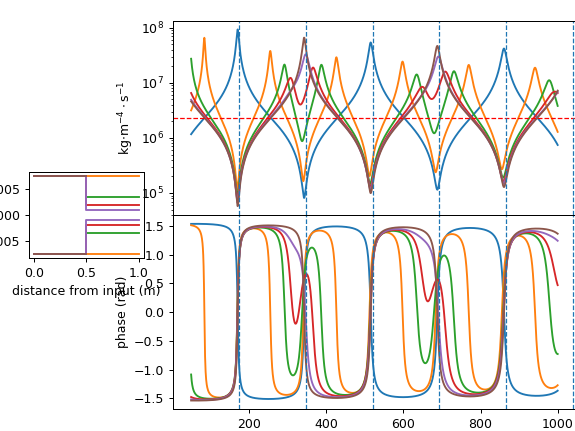

/home/goios/Envs/unsw/lib/python3.6/site-packages/pympedance-0.1-py3.6.egg/pympedance/Synthesiser.py:566: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


In [14]:
fvec = np.linspace(10,1000,1000)

#fig,ax=pl.subplots(2,sharex=True)

ax = None
for duct in ducts:
    if ax is None:
        ax=duct.plot_report( fmax=max(fvec), npoints=2000)
    else:
        duct.plot_report(ax=ax, fmax=max(fvec), npoints=2000)
    
ax[1].axhline((np.abs(duct.elements[0].get_characteristic_impedance())),
              lw=1,ls='--',color='r')

f=0
c=duct.speed_of_sound
while f < max(fvec):
    f+=c/(4*lb)
    ax[1].axvline(f,ls='--',lw=1)
    ax[2].axvline(f,ls='--',lw=1)

## Pressure transfer functions

Given two points along the duct (**pos**), what is the ratio of pressures, as a function of frequency? 

<IPython.core.display.Javascript object>


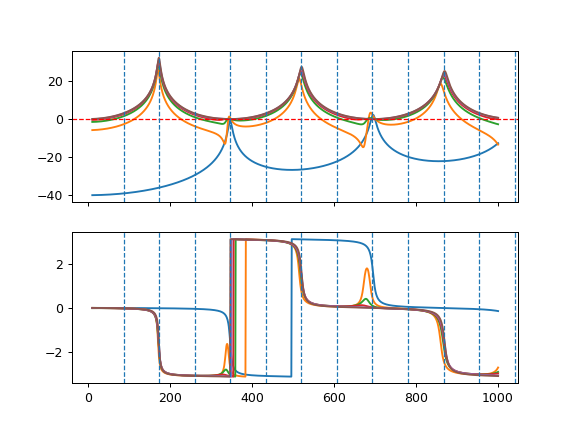

/home/goios/Envs/unsw/lib/python3.6/site-packages/pympedance-0.1-py3.6.egg/pympedance/Synthesiser.py:566: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)
/home/goios/Envs/unsw/lib/python3.6/site-packages/pympedance-0.1-py3.6.egg/pympedance/Synthesiser.py:262: RuntimeWarning: divide by zero encountered in true_divide
  z = p_st/u_st
/home/goios/Envs/unsw/lib/python3.6/site-packages/pympedance-0.1-py3.6.egg/pympedance/Synthesiser.py:262: RuntimeWarning: invalid value encountered in true_divide
  z = p_st/u_st
/home/goios/Envs/unsw/lib/python3.6/site-packages/pympedance-0.1-py3.6.egg/pympedance/Synthesiser.py:895: RuntimeWarning: invalid value encountered in multiply
  return z*self.char_impedance


In [15]:
fvec = np.linspace(10,1000,1000)

fig,ax=pl.subplots(2,sharex=True)

pos= [0.005,lb-0.005]

for duct in ducts:
    tf = duct.pressure_transfer_func(fvec,from_pos=pos[0],to_pos=pos[1])
    ax[0].plot(fvec,20*np.log10(np.abs(tf)))
    ax[1].plot(fvec,(np.angle(tf)))
    
ax[0].axhline(0, lw=1, ls='--', color='r')

f=0
c=duct.speed_of_sound
while f < max(fvec):
    f+=c/(4*l0)
    ax[0].axvline(f,ls='--',lw=1)
    ax[1].axvline(f,ls='--',lw=1)

## Element chaining checks

Check that transfer functions are independent of chaining order

In [16]:
def pressure_transfer_func(duct, freq=1.0, from_pos=0.0,
                           to_pos=None, ref_pos=None, reverse=False):
    """
    get the ratios of pressures at two positions in the duct
    """
    total_length = duct.get_total_length()
    if to_pos is None:
        # sys.stderr.write('\nsetting position to {}\n'.format(total_length))
        end_pos = total_length
    else:
        end_pos = to_pos

    if ref_pos is None:
        ref_pos = total_length

    cmx1 = duct.transfer_mx_at_freq(freq, from_pos=ref_pos,
                                    to_pos=from_pos, reverse=reverse)
    cmx2 = duct.transfer_mx_at_freq(freq, from_pos=ref_pos,
                                    to_pos=to_pos, reverse=reverse)
    z0 = (duct.get_input_impedance_at_freq(freq,
                                           from_pos=ref_pos))

    # set dummy variable to zero if z0 is infinite
    # (this will prevent nan for infinite impedances)
    one = np.isfinite(z0)
    z0[np.logical_not(one)] = 1.
    tfp = (cmx2[0,0]*z0 + cmx2[0,1]*one) / \
          (cmx1[0,0]*z0 + cmx1[0,1]*one)
    return tfp



<IPython.core.display.Javascript object>


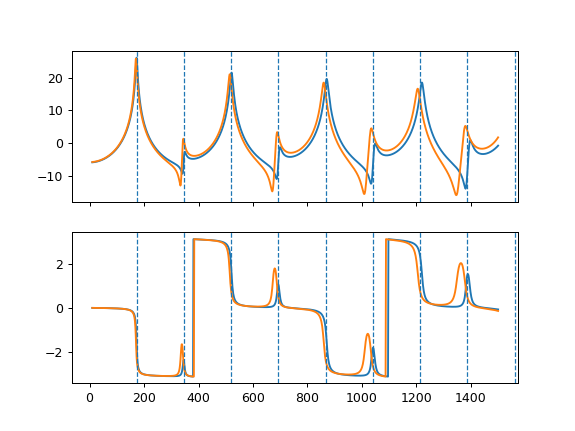

In [17]:
fvec = np.linspace(10,1500,1000)

fig,ax=pl.subplots(2,sharex=True)

pos= [0.005,lb-0.005]

duct=ducts[1]

tf = pressure_transfer_func(duct,fvec,from_pos=pos[0],to_pos=pos[1],reverse=False)

ax[0].plot(fvec,20*np.log10(np.abs(tf)))
ax[1].plot(fvec,(np.angle(tf)))

tf = pressure_transfer_func(duct,fvec,from_pos=pos[0],to_pos=pos[1],reverse=True)

ax[0].plot(fvec,20*np.log10(np.abs(tf)))
ax[1].plot(fvec,(np.angle(tf)))

#ax[1].axhline((np.abs(duct.elements[0].get_characteristic_impedance())),
#              lw=1,ls='--',color='r')

f=0
c=duct.speed_of_sound
while f < max(fvec):
    f+=c/(4*lb)
    ax[0].axvline(f,ls='--',lw=1)
    ax[1].axvline(f,ls='--',lw=1)

## effect of upstream mic position

<IPython.core.display.Javascript object>


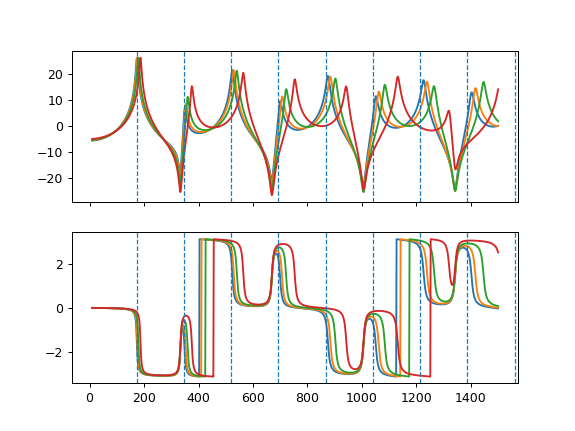

In [18]:
fvec = np.linspace(10,1500,1000)

fig,ax=pl.subplots(2,sharex=True)

pos2 = 0.02
for pos1 in (np.array([.5,1.,2.,4.])*pos2):
    pos= [pos1,lb-pos2]

    duct=ducts[1]

    tf = pressure_transfer_func(duct,fvec,from_pos=pos[0],to_pos=pos[1],reverse=False)

    ax[0].plot(fvec,20*np.log10(np.abs(tf)))
    ax[1].plot(fvec,(np.angle(tf)))


f=0
c=duct.speed_of_sound
while f < max(fvec):
    f+=c/(4*lb)
    ax[0].axvline(f,ls='--',lw=1)
    ax[1].axvline(f,ls='--',lw=1)

## Pressure distribution

<IPython.core.display.Javascript object>


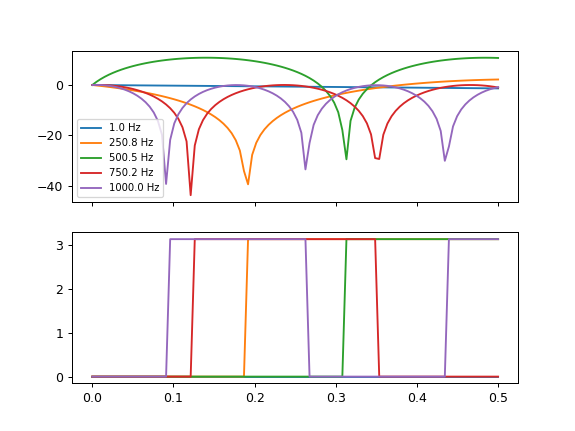

/home/goios/Envs/unsw/lib/python3.6/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


In [22]:
f = np.linspace(1.0,1000.0,5)

fig,ax=pl.subplots(2,sharex=True)

pos1 = 0.0

duct=ducts[2]

pos_l = (np.linspace(0.0,duct.elements[0].get_length(),100))
tf_l = np.zeros((len(pos_l),len(f)))

for ii, pos2 in enumerate(pos_l):
    pos= [pos1,pos2]

    tf = pressure_transfer_func(duct,f,from_pos=pos[0],to_pos=pos[1],reverse=False)
    
    tf_l[ii,:] = tf


for ii,ff in enumerate(f):
    ax[0].plot(pos_l,20*np.log10(np.abs(tf_l[:,ii])),label='%.1f Hz'%ff)
    ax[1].plot(pos_l,(np.angle(tf_l[:,ii])))
    
ax[0].legend(fontsize=8)



/home/goios/Envs/unsw/lib/python3.6/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


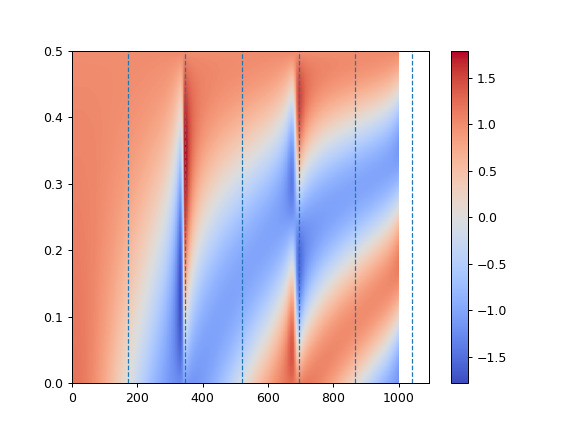

/home/goios/Envs/unsw/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/goios/Envs/unsw/lib/python3.6/site-packages/matplotlib/__init__.py:901: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/goios/Envs/unsw/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


<IPython.core.display.Javascript object>


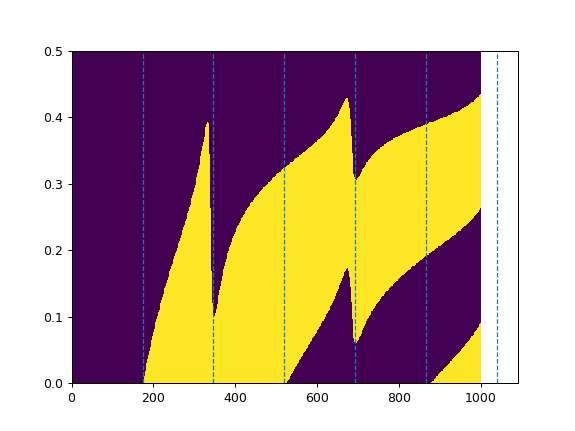

/home/goios/Envs/unsw/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


In [23]:
fvec = np.linspace(1.0,1000.0,500)


duct=ducts[2]
pos1 = duct.elements[0].get_length()-.005

pos_l = (np.linspace(0.0,duct.elements[0].get_length(),400))
tf_l = np.zeros((len(pos_l),len(fvec)))

for ii, pos2 in enumerate(pos_l):
    pos= [pos1,pos2]

    tf = pressure_transfer_func(duct,fvec,from_pos=pos[0],to_pos=pos[1],reverse=False)
    
    tf_l[ii,:] = tf


pl.figure()
#pl.imshow(np.log(np.abs(tf_l)),origin='lower',aspect='auto',extent=[min(f),max(f),min(pos_l),max(pos_l)])
vmax = np.max(np.abs(tf_l))
pl.imshow((np.abs(tf_l))*np.sign(np.real(tf_l)),origin='lower',aspect='auto',extent=[min(fvec),max(fvec),min(pos_l),max(pos_l)],cmap=pl.get_cmap('coolwarm'), vmin=-vmax,vmax=vmax)
pl.hold('on')
pl.colorbar()

f=0
c=duct.speed_of_sound
while f < max(fvec):
    f+=c/(4*lb)
    pl.axvline(f,ls='--',lw=1)

pl.figure()
pl.imshow((np.angle(tf_l)),origin='lower',aspect='auto',extent=[min(fvec),max(fvec),min(pos_l),max(pos_l)])

f=0
c=duct.speed_of_sound
pl.hold('on')
while f < max(fvec):
    f+=c/(4*lb)
    pl.axvline(f,ls='--',lw=1)


In [21]:
pl.imshow?